In [5]:
import torch
import torchaudio
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm



In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path.cwd().parents[1]
AUG_DIR = PROJECT_ROOT / "data/augmented_wavs"  # change if needed
DATA_DIR = PROJECT_ROOT / "data/wavs"

# Load pretrained ReDimNet (example config)
redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b2",      # or b3/b5/etc.
    train_type="ptn",     # or "ft_lm"/"ft_mix" depending what you want
    dataset="vox2",       # typical pretraining dataset
).to(DEVICE).eval()

# # # Save model layers to a text file
# model_str = repr(redim_model)
# with open("model_architecture.txt", "w") as f:
#     f.write(model_str)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


In [7]:
def embed_with_redim(wav_path: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)   # [C, T]
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]                  # take first channel

    wav = wav.to(DEVICE)
    with torch.no_grad():
        emb = redim_model(wav)           # [1, 192]
    return emb.squeeze(0).cpu().numpy()       # [192]

In [8]:
# %% VoxCeleb2 configuration (classification)

AUDIO_ROOT = (
    PROJECT_ROOT
    / "data"
    / "datasets"
    / "voxceleb2"
    / "voxceleb2_hf"
    / "extracted_aac"
    / "aac"
)

assert AUDIO_ROOT.exists(), f"Audio root not found: {AUDIO_ROOT}"

# discover all speakers on disk
ALL_SPEAKERS = sorted([p.name for p in AUDIO_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(ALL_SPEAKERS)} speakers on disk")

# take ONLY the first 50 speakers (controlled subset)
NUM_SPEAKERS = 10
MAX_SAMPLES_PER_SPEAKER = 20
SPEAKERS = ALL_SPEAKERS[:NUM_SPEAKERS]

# build class-id mappings (EXACTLY like eden/idan/yoav logic)
speaker_to_id = {s: i for i, s in enumerate(SPEAKERS)}
id_to_speaker = {i: s for s, i in speaker_to_id.items()}

print(f"Using {len(SPEAKERS)} speakers for classification task.")


def speaker_from_path(p: Path) -> str:
    """
    Given an audio file path, return speaker ID (idXXXXX).
    """
    return p.parents[1].name


# collect audio files (wav + m4a)
audio_paths = sorted(list(AUDIO_ROOT.rglob("*.wav")) + list(AUDIO_ROOT.rglob("*.m4a")))

# build dataset items (path, class_id, speaker_name)
all_items = []
for p in audio_paths:
    spk = speaker_from_path(p)

    # skip speakers not in our 50-speaker subset
    if spk not in speaker_to_id:
        continue

    # limit samples per speaker
    spk_count = sum(1 for _, _, s in all_items if s == spk)
    if spk_count >= MAX_SAMPLES_PER_SPEAKER:
        continue

    all_items.append((p, speaker_to_id[spk], spk))

print(f"Total audio files used: {len(all_items)}")

# optional sanity check
for s in SPEAKERS:
    count = sum(1 for _, _, sp in all_items if sp == s)
    print(s, "=", count)

Found 5558 speakers on disk
Using 10 speakers for classification task.
Total audio files used: 200
id00012 = 20
id00016 = 20
id00018 = 20
id00019 = 20
id00020 = 20
id00021 = 20
id00022 = 20
id00024 = 20
id00025 = 20
id00026 = 20


In [10]:
from collections import defaultdict
import random
import numpy as np

GLOBAL_ENROLL_PER_SPK = 3
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# group indices by speaker
groups = defaultdict(list)
for idx, (p, label, spk) in enumerate(all_items):
    groups[spk].append(idx)

In [11]:
enroll_idx = []
test_idx = []

for spk, idxs in groups.items():
    idxs = idxs.copy()
    random.shuffle(idxs)

    n_avail = len(idxs)

    if n_avail <= GLOBAL_ENROLL_PER_SPK:
        n_enroll = max(1, n_avail - 1)  # leave at least 1 test if possible
    else:
        n_enroll = GLOBAL_ENROLL_PER_SPK

    enroll_for_spk = idxs[:n_enroll]
    test_for_spk = idxs[n_enroll:]

    enroll_idx.extend(enroll_for_spk)
    test_idx.extend(test_for_spk)

enroll_idx = np.array(sorted(enroll_idx))
test_idx = np.array(sorted(test_idx))

In [12]:
print("Enrollment per speaker:", GLOBAL_ENROLL_PER_SPK)
print("Total enrollment files:", len(enroll_idx))
print("Total test files:", len(test_idx))

# sanity: no overlap
assert len(set(enroll_idx).intersection(set(test_idx))) == 0

# sanity: per speaker counts
for spk in SPEAKERS:
    spk_idxs = groups[spk]
    n_enroll = len(set(spk_idxs).intersection(enroll_idx))
    n_test = len(set(spk_idxs).intersection(test_idx))
    print(f"{spk}: enroll={n_enroll}, test={n_test}")

Enrollment per speaker: 3
Total enrollment files: 30
Total test files: 170
id00012: enroll=3, test=17
id00016: enroll=3, test=17
id00018: enroll=3, test=17
id00019: enroll=3, test=17
id00020: enroll=3, test=17
id00021: enroll=3, test=17
id00022: enroll=3, test=17
id00024: enroll=3, test=17
id00025: enroll=3, test=17
id00026: enroll=3, test=17


In [14]:
import numpy as np
import torch
from tqdm import tqdm

embs = []
paths = []

with torch.no_grad():
    for p, label, spk in tqdm(all_items, desc="Extracting embeddings"):
        vec = embed_with_redim(str(p))  # [192]
        embs.append(vec)
        paths.append(p)

# Stack to matrix
E = np.vstack(embs).astype("float32")  # [N, 192]
print("Embedding matrix shape:", E.shape)

# ======================
# Safe L2-normalization
# ======================
norms = np.linalg.norm(E, axis=1, keepdims=True)
norms[norms == 0] = 1.0  # avoid division by zero

E_norm = E / norms

Extracting embeddings: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]

Embedding matrix shape: (200, 192)


In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ======================
# Build speaker labels aligned with embeddings
# ======================
# all_items: list of (path, class_id, speaker)
all_speakers = np.array([spk for _, _, spk in all_items])

# ======================
# Split embeddings + labels
# ======================
enroll_emb = E_norm[enroll_idx]
test_emb = E_norm[test_idx]

enroll_labels = all_speakers[enroll_idx]
test_labels = all_speakers[test_idx]

print("Enroll embeddings:", enroll_emb.shape)
print("Test embeddings:", test_emb.shape)

# ======================
# Closed-set identification via cosine similarity
# ======================
pred_labels = []

for e in test_emb:
    sims = cosine_similarity(e.reshape(1, -1), enroll_emb)[0]  # [N_enroll]
    best_idx = np.argmax(sims)
    pred_labels.append(enroll_labels[best_idx])

pred_labels = np.array(pred_labels)

# ======================
# Accuracy
# ======================
accuracy = (pred_labels == test_labels).mean()
print(f"Closed-set identification accuracy: {accuracy*100:.2f}%")

# ======================
# Optional: per-speaker accuracy
# ======================
print("\nPer-speaker accuracy:")
for spk in np.unique(test_labels):
    mask = test_labels == spk
    acc_spk = (pred_labels[mask] == test_labels[mask]).mean()
    print(f"{spk}: {acc_spk*100:.2f}%")

Enroll embeddings: (30, 192)
Test embeddings: (170, 192)
Closed-set identification accuracy: 97.65%

Per-speaker accuracy:
id00012: 100.00%
id00016: 100.00%
id00018: 100.00%
id00019: 100.00%
id00020: 100.00%
id00021: 100.00%
id00022: 100.00%
id00024: 100.00%
id00025: 100.00%
id00026: 76.47%


PCA shape: (200, 10)

Explained variance per component:
PC1: 11.42%
PC2: 10.41%
PC3: 9.97%
PC4: 8.42%
PC5: 7.58%
PC6: 6.95%
PC7: 5.81%
PC8: 5.62%
PC9: 5.32%
PC10: 2.17%

Cumulative variance (10 PCs): 73.69%


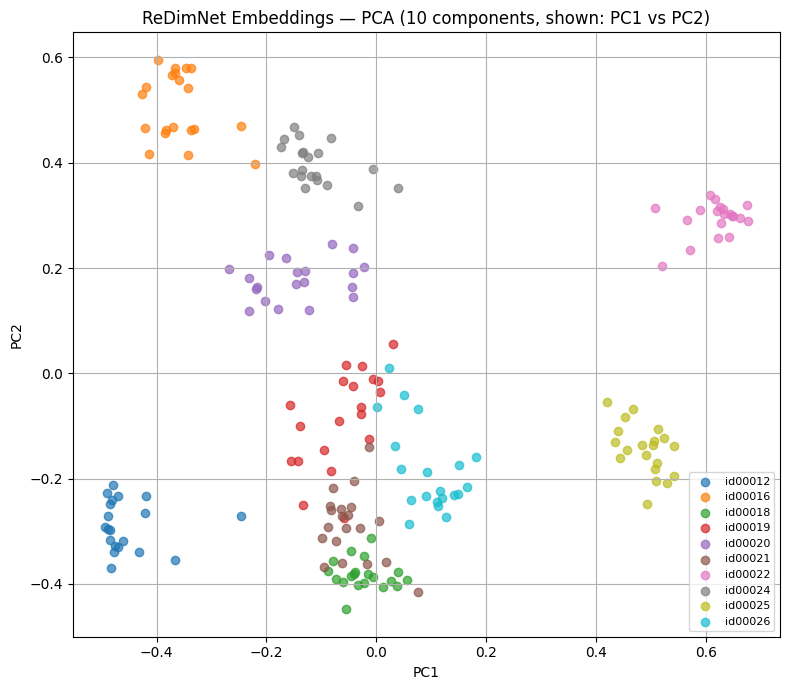

In [18]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# ======================
# Speaker labels aligned with embeddings
# ======================
# all_items: (path, class_id, speaker)
speakers_all = np.array([spk for _, _, spk in all_items])
unique_speakers = np.unique(speakers_all)

# ======================
# PCA (10 components)
# ======================
pca = PCA(n_components=10, random_state=0)
X_pca_10 = pca.fit_transform(E_norm)  # shape [N, 10]

print("PCA shape:", X_pca_10.shape)

# Explained variance
expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

print("\nExplained variance per component:")
for i, v in enumerate(expl_var, 1):
    print(f"PC{i}: {v*100:.2f}%")

print(f"\nCumulative variance (10 PCs): {cum_var[-1]*100:.2f}%")

# ======================
# 2D visualization (PC1 vs PC2)
# ======================
plt.figure(figsize=(8, 7))

for spk in unique_speakers:
    idx = speakers_all == spk
    plt.scatter(X_pca_10[idx, 0], X_pca_10[idx, 1], alpha=0.7, label=spk)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet Embeddings — PCA (10 components, shown: PC1 vs PC2)")
plt.legend(markerscale=1, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()